<a href="https://colab.research.google.com/github/emmigalfo/AnimeSage/blob/main/Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modeling

###About the modeling used in this project


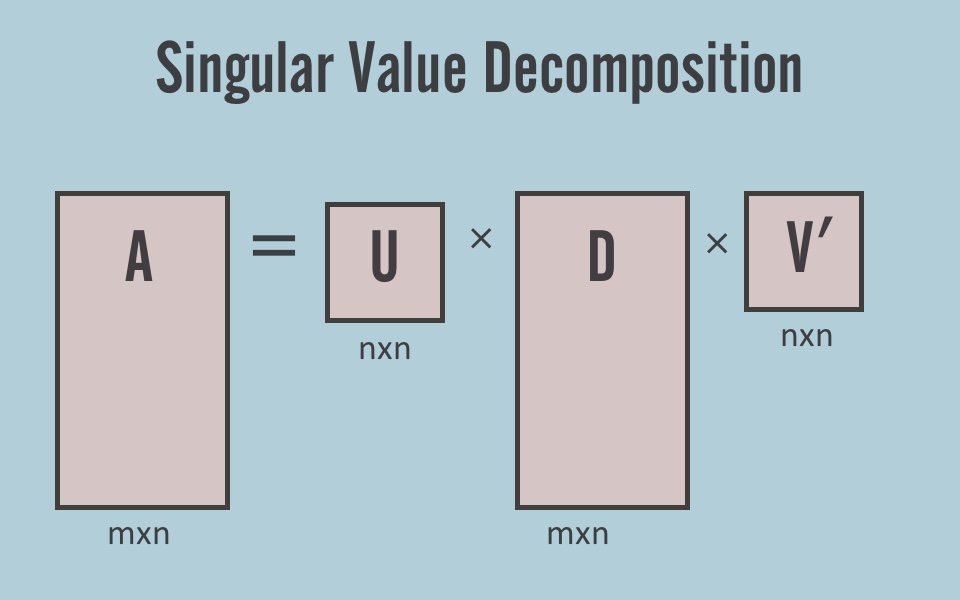

__Algorithm:__
Singular Value Decomposition (SVD) has been widely recognized for its efficacy in recommendation systems, particularly in scenarios involving large datasets with user-item interactions. In the context of my anime recommender system, SVD can be instrumental in deciphering latent features that underline the interactions between users and anime titles.

__How it works:__
Essentially, SVD decomposes the the user-anime ratings matrix into three separate matrices, revealing the hidden features that connect the users and anime in a lower-dimensional space. This enables the prediction of unobserved user-item interactions and allows the system to recommend animes that a user might prefer. For instance, the paper "A music recommendation system based on collaborative filtering and SVD" by Yu-Chuan Chen demonstrates that SVD outperforms item-based collaborative filtering in music recommendations[^3^]. Moreover, the "Rec-CFSVD++: Implementing Recommendation System Using Collaborative Filtering and Singular Value Decomposition (SVD)++" paper illustrates a practical hybrid implementation of SVD++ in a recommendation system, showcasing its capability to predict missing ratings and recommend top-N user-preferred items by leveraging both explicit and implicit feedback[^4^].

[^3^]: [A music recommendation system based on collaborative filtering and SVD](https://dx.doi.org/10.1109/TOCS56154.2022.10016210)
[^4^]: [Rec-CFSVD++: Implementing Recommendation System Using Collaborative Filtering and Singular Value Decomposition (SVD)++](https://dx.doi.org/10.1142/S0219622021500310)

In [ ]:
# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# I'm using google colab so I need to import drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [ ]:
# Import modeling dataset (See EDA notebook on preprocessing steps)
full_data = pd.read_csv('/content/drive/My Drive/anime_project/modeling_df.csv')
full_data.head()

,user_id,MAL_ID,rating,Name,Genres,Popularity
0,0,430,9,Fullmetal Alchemist:The Movie - Conqueror of S...,"Military, Comedy, Historical, Drama, Fantasy, ...",506
1,18,430,10,Fullmetal Alchemist:The Movie - Conqueror of S...,"Military, Comedy, Historical, Drama, Fantasy, ...",506
2,33,430,4,Fullmetal Alchemist:The Movie - Conqueror of S...,"Military, Comedy, Historical, Drama, Fantasy, ...",506
3,41,430,7,Fullmetal Alchemist:The Movie - Conqueror of S...,"Military, Comedy, Historical, Drama, Fantasy, ...",506
4,52,430,10,Fullmetal Alchemist:The Movie - Conqueror of S...,"Military, Comedy, Historical, Drama, Fantasy, ...",506


When I created the data subset for modeling, I kept the columns Name, Genres, and Popularity. Although I only do collaborative filtering models in this project, Genres was kept for continuing work on building a future hybrid content-based model. Name and popularity where kept for use later in deployment of an app.

In [ ]:
# The SVD model that I am using only needs three columns
# Keep only necessary columns for SVD modeling
df_modeling = full_data[['user_id', 'MAL_ID', 'rating']]
df_modeling.head()

,user_id,MAL_ID,rating
0,0,430,9
1,18,430,10
2,33,430,4
3,41,430,7
4,52,430,10


Although I have 51GB of RAM available using colab pro, the dataframe is so large that it exceeds this and will crash everytime unless I significantly reduce it. I reduced the dataset randomly (with a seed to maintain reproducability). Through some trial and error, I found that keeping 33 percent of the dataset is still very large, but is just reduced enough to be able to run the models.

In [ ]:
# Reduce size of dataset inorder to reduce RAM needed for modeling
np.random.seed(42)

percentage_to_keep = 0.33

# Get a random sample of unique user_ids to keep
unique_user_ids = df_modeling['user_id'].unique()
num_to_keep = int(len(unique_user_ids) * percentage_to_keep)
user_ids_to_keep = np.random.choice(unique_user_ids, num_to_keep, replace=False)

# Filter the DataFrame to keep only rows with user_ids in user_ids_to_keep
df_reduced = df_modeling[df_modeling['user_id'].isin(user_ids_to_keep)]

In [ ]:
# Compare shapes of dataset before and after reducing
print(f'shape of df_moding: {df_modeling.shape}')
print(f'shape of df_reduced: {df_reduced.shape}')

shape of df_moding: (24527428, 3)
shape of df_reduced: (8050551, 3)


__Insights:__

Although the dataset is reduced it still has over 8 million rows. This should be enough to build a robust recommender system.

In [ ]:
# Save reduced dataset to read in during future work, this makes the notebook faster to load.
df_reduced.to_csv('/content/drive/My Drive/anime_project/anime_ratings_reduced.csv', index=False)

## Model 1- Simple Baseline

I will start by using the **average rating** as a simple baseline.

- **Uniform Predictions:** The model predicts the same rating (the overall average rating) for all items, regardless of the user or item characteristics. It doesn’t account for any variations or patterns in user behavior or item properties.
  
- **Ease of Implementation:** The model is easy to implement and understand, requiring only basic statistical calculations (mean and RMSE) without the need for complex algorithms or training processes.

- **Benchmarking:** Despite its simplicity and the fact that it doesn’t use user or item data to make predictions, this model provides a baseline RMSE that can be used to evaluate the effectiveness of more sophisticated models. If a more complex model cannot outperform this simple baseline, it may indicate issues with the model or the data.

This baseline model serves as a reference point in the development and evaluation of more advanced recommendation algorithms.

In [ ]:
# Create a baseline model
# Taking the mean of the ratings
baseline_pred = df_reduced['rating'].mean()
# Subtract the actual values from the mean rating score to get the errors.
# Take the square root of the average of the errors squared.
baseline_rmse = np.sqrt(np.mean((df_reduced['rating'] - baseline_pred)**2))
# Output the baseline RMSE.
print(f"Baseline RMSE: {baseline_rmse:.4f}")

Baseline RMSE: 1.6377


__Insights:__
This RMSE value serves as a benchmark for evaluating more sophisticated models. Any advanced model should ideally achieve an RMSE lower than
1.6377 to be considered an improvement in predictive accuracy over the baseline.

## Model 2- SVD

The Surprise library is recognized for its simplicity and efficiency in developing recommendation systems, providing a straightforward API and implementation of algorithms like SVD. It facilitates easy deployment and testing of recommendation systems, supports various evaluation metrics, and manages different data structures and large datasets effectively. According to the library's official documentation, Surprise enables "to give users perfect control over their experiments" and aims to provide "various ready-to-use prediction algorithms" such as SVD.

[^1^]: [Surprise Documentation](http://surpriselib.com/)

In [3]:
# Install surprise package
!pip install surprise

  Using cached surprise-0.1-py2.py3-none-any.whl (1.8 kB)
  Using cached scikit-surprise-1.1.3.tar.gz (771 kB)
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp310-cp310-linux_x86_64.whl size=3163327 sha256=7573709ef7010dcd119e13241e3d4a7c069068d4cd3bd1f34002c7ef2614ed13
  Stored in directory: /root/.cache/pip/wheels/a5/ca/a8/4e28def53797fdc4363ca4af740db15a9c2f1595ebc51fb445
Successfully built scikit-surprise


In [ ]:
# Import Surprise
from surprise import Reader, Dataset, SVD, accuracy
from surprise.model_selection import cross_validate, train_test_split
from surprise.prediction_algorithms import SVD
from surprise.model_selection import GridSearchCV

In [ ]:
# Use the Surprise Reader and Dataset to read in data
reader = Reader(rating_scale=(1, 10))
data = Dataset.load_from_df(df_reduced, reader=reader)

In [ ]:
# Create a train test split
trainset, testset = train_test_split(data, test_size=.2, random_state=42)

In [ ]:
# Instatiate svd
svd = SVD(random_state=42)

# Fit to the training set
svd.fit(trainset)

# Create predictions
predictions = svd.test(testset)

# Measure the accuracy of the predictions
rmse = accuracy.rmse(predictions)
print("RMSE:", rmse)

RMSE: 1.1808
RMSE: 1.1807708462620254


__Insights:__ On a rating scale up to 10, an RMSE of 1.1808 suggests that, on average, the model's predictions are approximately 1.18 points off from the actual user ratings. This is a relatively low error and suggests a decent level of accuracy. It is an improvement from the simple baseline model.  

## Model 3- Tuning with Grid Search

Just to see if we can get any better, let's try using a grid search to adjust hyperparameters. This will allow us to see how we can best tune the model.

In [ ]:
# Define the parameter grid with different settings for
# number of factors, epochs, learning rate and regulation.
param_grid = {
    'n_factors': [5, 15, 20],
    'n_epochs': [5, 10, 25],
    'lr_all': [0.002, 0.005, 0.01],
    'reg_all': [0.02, 0.04, 0.06]
}

# Create a GridSearchCV object
grid_search = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=5, n_jobs=-1, joblib_verbose=6)

# Fit the grid search to the data
grid_search.fit(data)

# Print the best RMSE and corresponding hyperparameters
print("Best RMSE: {:.4f}".format(grid_search.best_score['rmse']))
print("Best Parameters:", grid_search.best_params['rmse'])

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  8.4min
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed: 24.0min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 45.0min
[Parallel(n_jobs=-1)]: Done 297 tasks      | elapsed: 73.6min


Best RMSE: 1.1657
Best Parameters: {'n_factors': 20, 'n_epochs': 25, 'lr_all': 0.005, 'reg_all': 0.04}


[Parallel(n_jobs=-1)]: Done 405 out of 405 | elapsed: 102.4min finished


__Insights:__ The grid search used cross validation to determine the best parameters.  We can input these paramaters into the model and see how tuning it helps performance.

In [ ]:
# Instatiate svd with best parameters from grid search
svd = SVD(n_factors=20, n_epochs=25, lr_all=0.005, reg_all=0.04, random_state=42)

# Fit to the training set
svd.fit(trainset)

# Create predictions
predictions = svd.test(testset)

# Measure the accuracy of the predictions
rmse = accuracy.rmse(predictions)
print("RMSE:", rmse)

RMSE: 1.1686
RMSE: 1.1685607435314915


__Insights:__ The model performed slightly better than before it was tuned. Overall an RMSE of 1.17 is a great start for our recommender system. If the system recommends something thinking the user would rate it a 10 but the user would actually rate it an 8.9, it's still a solid recommendation.

## Final Model

Next, we need to train the model on the entire dataset in order to use it for recommendations (otherwise we would be missing the test set).

In [ ]:
# Train the model on the whole reduced dataset
# Instantiate an SVD model
svd_final = SVD(n_factors=20, n_epochs=25, lr_all=0.005, reg_all=0.04, random_state=42)

# Fit the SVD model on the entire dataset
trainset = data.build_full_trainset()  # Build a trainset from the entire dataset
svd_final.fit(trainset)

We can pickle the model in order to use the model in the future without retraining it.

In [ ]:
# Import package for saving model
import joblib

# Save the model
joblib.dump(svd_final, '/content/drive/My Drive/anime_project/svd_model.pkl')

['/content/drive/My Drive/anime_project/svd_model.pkl']

## Deployment

In [ ]:
names_df = full_data[['MAL_ID', 'Name']]
names_df.head()


,MAL_ID,Name
0,430,Fullmetal Alchemist:The Movie - Conqueror of S...
1,430,Fullmetal Alchemist:The Movie - Conqueror of S...
2,430,Fullmetal Alchemist:The Movie - Conqueror of S...
3,430,Fullmetal Alchemist:The Movie - Conqueror of S...
4,430,Fullmetal Alchemist:The Movie - Conqueror of S...


In [ ]:
names_df = names_df.copy()
names_df.drop_duplicates(subset='MAL_ID', inplace=True)
names_df.head()

,MAL_ID,Name
0,430,Fullmetal Alchemist:The Movie - Conqueror of S...
26454,1004,She and Her Cat:Their Standing Points
35227,3010,The Magnificent Zorro
35895,570,Jin-Roh:The Wolf Brigade
42762,2762,Igano Kabamaru


In [ ]:
names_df.MAL_ID.value_counts().describe()

count    11225.0
mean         1.0
std          0.0
min          1.0
25%          1.0
50%          1.0
75%          1.0
max          1.0
Name: MAL_ID, dtype: float64

In [ ]:
names_df.head()

,MAL_ID,Name
18048844,7669,"""Bungaku Shoujo"" Kyou no Oyatsu: Hatsukoi"
16614751,8481,"""Bungaku Shoujo"" Memoire"
16624814,6408,"""Bungaku Shoujo"" Movie"
24513753,38045,"""Calpis"" Hakkou Monogatari"
24424219,6076,"""Eiji"""


In [ ]:
# Sort the DataFrame in alphabetical order by 'Name'
names_df.sort_values(by='Name', inplace=True)
# Save to drive
names_df.to_csv('/content/drive/My Drive/anime_project/anime_names.csv', index=False)

In [ ]:
popular_anime = full_data[['MAL_ID', 'Name', 'Popularity']]
popular_anime.drop_duplicates(subset='MAL_ID', inplace=True)
popular_anime.sort_values(by='Popularity', inplace=True)
popular_anime_df = popular_anime.head(50).copy()
popular_anime_df


<ipython-input-11-db40c8f211b1>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  popular_anime.drop_duplicates(subset='MAL_ID', inplace=True)
<ipython-input-11-db40c8f211b1>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  popular_anime.sort_values(by='Popularity', inplace=True)


,MAL_ID,Name,Popularity
2232483,1535,Death Note,1
3671068,16498,Attack on Titan,2
2067376,5114,Fullmetal Alchemist:Brotherhood,3
3003135,11757,Sword Art Online,4
3327846,30276,One Punch Man,5
1731584,31964,My Hero Academia,6
4246062,22319,Tokyo Ghoul,7
1227959,20,Naruto,8
2856747,9253,Steins;Gate,9
3242519,19815,"No Game, No Life",10


In [ ]:
# Save to drive
popular_anime_df.to_csv('/content/drive/My Drive/anime_project/popular_anime.csv', index=False)

**NEXT STEPS: Content Based Model**

In [ ]:
cb_df = full_data.copy()
cb_df = full_data[['user_id', 'MAL_ID', 'rating', 'Genres']]

# Keep only rows where 'user_id' is in df_reduced
cb_df = cb_df[cb_df['user_id'].isin(df_reduced['user_id'])]

cb_df.head()



,user_id,MAL_ID,rating,Genres
4,52,430,10,"Military, Comedy, Historical, Drama, Fantasy, ..."
6,88,430,8,"Military, Comedy, Historical, Drama, Fantasy, ..."
11,165,430,10,"Military, Comedy, Historical, Drama, Fantasy, ..."
12,195,430,8,"Military, Comedy, Historical, Drama, Fantasy, ..."
20,275,430,10,"Military, Comedy, Historical, Drama, Fantasy, ..."


In [ ]:
# Import necessary libraries
from sklearn.model_selection import train_test_split

# Splitting the data into training and test sets
train_data, test_data = train_test_split(
    cb_df,
    stratify=cb_df['user_id'],  # Ensure all users are represented in train/test
    test_size=0.2,  # Use 80% of the data for training, 20% for testing
    random_state=42  # Set random state for reproducibility
)

# Resetting index for convenience
train_data.reset_index(drop=True, inplace=True)
test_data.reset_index(drop=True, inplace=True)

# Displaying the first few rows of train_data and test_data
train_data.head(), test_data.head()

(   user_id  MAL_ID  rating                                        Genres
 0   210886   32664       7                   Slice of Life, Comedy, Kids
 1   310778   38883       8        Comedy, Sports, Drama, School, Shounen
 2   297380   28725       9                        Drama, Romance, School
 3    41646   40776      10        Comedy, Sports, Drama, School, Shounen
 4   335127   18507       9  Slice of Life, Comedy, Sports, Drama, School,
    user_id  MAL_ID  rating                                         Genres
 0    63984   14741       9  Slice of Life, Comedy, Drama, Romance, School
 1   195823   38572       7                                        Fantasy
 2    47995    1691       8       Action, Magic, Romance, Fantasy, Shounen
 3   342044   19151       7  Action, Ecchi, Romance, Harem, School, Sports
 4   311720   11741      10           Action, Supernatural, Magic, Fantasy)

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import mean_squared_error
from scipy.sparse import csr_matrix

# Replace NaN values with an empty string
train_data['Genres'].fillna('', inplace=True)

# Create a vectorizer
vectorizer = CountVectorizer(tokenizer=lambda x: x.split(', '))
genre_matrix = vectorizer.fit_transform(train_data['Genres'])

# Creating a DataFrame with one-hot encoded genres
genre_df = pd.DataFrame(
    genre_matrix.toarray(),
    columns=vectorizer.get_feature_names_out(),
    index=train_data.index
)

# Concatenating the one-hot encoded genres with train_data
train_data_encoded = pd.concat([train_data, genre_df], axis=1)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [ ]:
train_data_encoded.head()


,user_id,MAL_ID,rating,Genres,,action,adventure,cars,comedy,dementia,...,shounen ai,slice of life,space,sports,super power,supernatural,thriller,vampire,yaoi,yuri
0,210886,32664,7,"Slice of Life, Comedy, Kids",0,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,0
1,310778,38883,8,"Comedy, Sports, Drama, School, Shounen",0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
2,297380,28725,9,"Drama, Romance, School",0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,41646,40776,10,"Comedy, Sports, Drama, School, Shounen",0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
4,335127,18507,9,"Slice of Life, Comedy, Sports, Drama, School",0,0,0,0,1,0,...,0,1,0,1,0,0,0,0,0,0


**Build User Profiles**

In [ ]:
# Creating a user profile by taking the dot product of the user's ratings and the genre matrix
user_profiles = train_data_encoded.groupby('user_id').apply(
    lambda x: x.iloc[:, -genre_df.shape[1]:].T @ x['rating']
)

# Convert user and item profiles to sparse matrices to conserve memory
user_profiles_sparse = csr_matrix(user_profiles.values)
genre_matrix_sparse = csr_matrix(genre_matrix)


**Generate Predictions**

In [ ]:
# Convert user and item profiles to sparse matrices to conserve memory
user_profiles_sparse = csr_matrix(user_profiles.values)
genre_matrix_sparse = csr_matrix(genre_matrix)

# Creating mappings from IDs to indices
user_id_to_idx = {user_id: idx for idx, user_id in enumerate(train_data['user_id'].unique())}
item_id_to_idx = {item_id: idx for idx, item_id in enumerate(train_data['MAL_ID'].unique())}

# Parameters
batch_size = 1000  # Define a suitable batch size
n_items = genre_matrix_sparse.shape[0]
rmse_list = []

# Diagnostic: Print matrix shapes and mappings
print(f'User profiles matrix shape: {user_profiles_sparse.shape}')
print(f'Genre matrix shape: {genre_matrix_sparse.shape}')
print(f'User ID to index mapping: {list(user_id_to_idx.items())[:5]}...')
print(f'Item ID to index mapping: {list(item_id_to_idx.items())[:5]}...')

User profiles matrix shape: (80500, 44)
Genre matrix shape: (6768524, 44)
User ID to index mapping: [(210886, 0), (310778, 1), (297380, 2), (41646, 3), (335127, 4)]...
Item ID to index mapping: [(32664, 0), (38883, 1), (28725, 2), (40776, 3), (18507, 4)]...


Evaluate the Model

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import mean_squared_error
from scipy.sparse import csr_matrix

# Assuming cb_df is your DataFrame containing 'user_id', 'MAL_ID', 'rating', and 'Genres'
# Replace NaN values with an empty string
train_data['Genres'].fillna('', inplace=True)

# Create a vectorizer
vectorizer = CountVectorizer(tokenizer=lambda x: x.split(', '))
genre_matrix = vectorizer.fit_transform(train_data['Genres'])

# Creating a DataFrame with one-hot encoded genres
genre_df = pd.DataFrame(
    genre_matrix.toarray(),
    columns=vectorizer.get_feature_names_out(),
    index=train_data.index
)

# Concatenating the one-hot encoded genres with train_data
train_data_encoded = pd.concat([train_data, genre_df], axis=1)

# Creating a user profile by taking the dot product of the user's ratings and the genre matrix
user_profiles = train_data_encoded.groupby('user_id').apply(
    lambda x: x.iloc[:, -genre_df.shape[1]:].T @ x['rating']
)

# Convert user and item profiles to sparse matrices to conserve memory
user_profiles_sparse = csr_matrix(user_profiles.values)
genre_matrix_sparse = csr_matrix(genre_matrix)

# Creating mappings from IDs to indices
user_id_to_idx = {user_id: idx for idx, user_id in enumerate(train_data['user_id'].unique())}
item_id_to_idx = {item_id: idx for idx, item_id in enumerate(train_data['MAL_ID'].unique())}

# Parameters
batch_size = 1000  # Define a suitable batch size
n_items = genre_matrix_sparse.shape[0]
rmse_list = []

# Diagnostic: Print matrix shapes and mappings
print(f'User profiles matrix shape: {user_profiles_sparse.shape}')
print(f'Genre matrix shape: {genre_matrix_sparse.shape}')
print(f'User ID to index mapping: {list(user_id_to_idx.items())[:5]}...')
print(f'Item ID to index mapping: {list(item_id_to_idx.items())[:5]}...')

# Loop through batches of items
for i in range(0, n_items, batch_size):
    # Select batch of items
    item_batch = genre_matrix_sparse[i:i+batch_size]

    # Compute predictions for the batch
    batch_predictions = user_profiles_sparse.dot(item_batch.T)

    # Identify test data relevant to the batch
    batch_test_data = test_data[test_data['MAL_ID'].isin(range(i, i+batch_size))].copy()

    # Map user and item IDs to indices
    batch_test_data['user_idx'] = batch_test_data['user_id'].map(user_id_to_idx)
    batch_test_data['item_idx'] = batch_test_data['MAL_ID'].map(item_id_to_idx) - i  # Adjust item indices for the current batch

    # Diagnostic: Print test data and batch predictions shape
    print(f'\nBatch test data (first 5 rows):\n{batch_test_data.head()}')
    print(f'Batch predictions shape: {batch_predictions.shape}')

    # Additional Diagnostic: Check index ranges and NaN mappings
    print(f'Max user index in batch test data: {batch_test_data["user_idx"].max()}')
    print(f'Max item index in batch test data: {batch_test_data["item_idx"].max()}')
    print(f'Are there NaNs in user indices? {batch_test_data["user_idx"].isna().any()}')
    print(f'Are there NaNs in item indices? {batch_test_data["item_idx"].isna().any()}')

    # Extract actual ratings and predicted ratings
    actual_ratings = batch_test_data['rating'].values
    predicted_ratings = batch_predictions[batch_test_data['user_idx'].values, batch_test_data['item_idx'].values].A1

    # Compute RMSE for the batch and append to the list
    batch_rmse = np.sqrt(mean_squared_error(actual_ratings, predicted_ratings))
    rmse_list.append(batch_rmse)

# Compute the final RMSE as the average of batch RMSEs
final_rmse = np.mean(rmse_list)
final_rmse

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


User profiles matrix shape: (80500, 44)
Genre matrix shape: (6768524, 44)
User ID to index mapping: [(210886, 0), (310778, 1), (297380, 2), (41646, 3), (335127, 4)]...
Item ID to index mapping: [(32664, 0), (38883, 1), (28725, 2), (40776, 3), (18507, 4)]...

Batch test data (first 5 rows):
    user_id  MAL_ID  rating  \
5    154727     288       9   
9    230751     136       8   
15    70213     125       7   
19   178668       1       9   
20   301803     431      10   

                                               Genres  user_idx  item_idx  
5   Action, Sci-Fi, Adventure, Comedy, Sports, Sho...     62930      1184  
9    Action, Adventure, Super Power, Fantasy, Shounen     18792       810  
15                            Comedy, Romance, School     40186      1306  
19    Action, Adventure, Comedy, Drama, Sci-Fi, Space      4976       292  
20                 Adventure, Drama, Fantasy, Romance     63527        95  
Batch predictions shape: (80500, 1000)
Max user index in batch tes

IndexError: ignored

In [ ]:
# Assuming cb_df is your DataFrame containing 'user_id', 'MAL_ID', 'rating', and 'Genres'
# Replace NaN values with an empty string
train_data['Genres'].fillna('', inplace=True)

# Create a vectorizer
vectorizer = CountVectorizer(tokenizer=lambda x: x.split(', '))
genre_matrix = vectorizer.fit_transform(train_data['Genres'])

# Creating a DataFrame with one-hot encoded genres
genre_df = pd.DataFrame(
    genre_matrix.toarray(),
    columns=vectorizer.get_feature_names_out(),
    index=train_data.index
)

# Concatenating the one-hot encoded genres with train_data
train_data_encoded = pd.concat([train_data, genre_df], axis=1)

# Creating a user profile by taking the dot product of the user's ratings and the genre matrix
user_profiles = train_data_encoded.groupby('user_id').apply(
    lambda x: x.iloc[:, -genre_df.shape[1]:].T @ x['rating']
)

# Convert user and item profiles to sparse matrices to conserve memory
user_profiles_sparse = csr_matrix(user_profiles.values)
genre_matrix_sparse = csr_matrix(genre_matrix)

# Creating mappings from IDs to indices
user_id_to_idx = {user_id: idx for idx, user_id in enumerate(train_data['user_id'].unique())}
item_id_to_idx = {item_id: idx for idx, item_id in enumerate(train_data['MAL_ID'].unique())}

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [ ]:
# Parameters
batch_size = 1000  # Define a suitable batch size
n_items = genre_matrix_sparse.shape[0]
rmse_list = []

# Diagnostic: Print matrix shapes and mappings
print(f'User profiles matrix shape: {user_profiles_sparse.shape}')
print(f'Genre matrix shape: {genre_matrix_sparse.shape}')
print(f'User ID to index mapping: {list(user_id_to_idx.items())[:5]}...')
print(f'Item ID to index mapping: {list(item_id_to_idx.items())[:5]}...')

# Loop through batches of items
for i in range(0, n_items, batch_size):
    # Select batch of items
    item_batch = genre_matrix_sparse[i:i+batch_size]

    # Compute predictions for the batch
    batch_predictions = user_profiles_sparse.dot(item_batch.T)

    # Identify test data relevant to the batch
    batch_test_data = test_data[test_data['MAL_ID'].isin(range(i, i+batch_size))].copy()

    # Map user and item IDs to indices
    batch_test_data['user_idx'] = batch_test_data['user_id'].map(user_id_to_idx)
    batch_test_data['item_idx'] = batch_test_data['MAL_ID'].map(item_id_to_idx) - i  # Adjust item indices for the current batch

    # Ensure user_idx is within the range of user_profiles_sparse
    batch_test_data = batch_test_data[batch_test_data['user_idx'] < user_profiles_sparse.shape[0]]

    # Diagnostic: Print test data and batch predictions shape
    print(f'\nBatch test data (first 5 rows):\n{batch_test_data.head()}')
    print(f'Batch predictions shape: {batch_predictions.shape}')

    # Additional Diagnostic: Check index ranges and NaN mappings
    print(f'Max user index in batch test data: {batch_test_data["user_idx"].max()}')
    print(f'Max item index in batch test data: {batch_test_data["item_idx"].max()}')
    print(f'Are there NaNs in user indices? {batch_test_data["user_idx"].isna().any()}')
    print(f'Are there NaNs in item indices? {batch_test_data["item_idx"].isna().any()}')

    # Extract actual ratings
    actual_ratings = batch_test_data['rating'].values

    predicted_ratings = np.array([
      batch_predictions.toarray()[user_idx, item_idx]
      for user_idx, item_idx in zip(batch_test_data['user_idx'].values, batch_test_data['item_idx'].values)
      ])

    # Compute RMSE for the batch and append to the list
    batch_rmse = np.sqrt(mean_squared_error(actual_ratings, predicted_ratings))
    rmse_list.append(batch_rmse)

# Compute the overall RMSE
overall_rmse = np.mean(rmse_list)
print(f'\nOverall RMSE: {overall_rmse}')

User profiles matrix shape: (80500, 44)
Genre matrix shape: (6768524, 44)
User ID to index mapping: [(210886, 0), (310778, 1), (297380, 2), (41646, 3), (335127, 4)]...
Item ID to index mapping: [(32664, 0), (38883, 1), (28725, 2), (40776, 3), (18507, 4)]...

Batch test data (first 5 rows):
    user_id  MAL_ID  rating  \
5    154727     288       9   
9    230751     136       8   
15    70213     125       7   
19   178668       1       9   
20   301803     431      10   

                                               Genres  user_idx  item_idx  
5   Action, Sci-Fi, Adventure, Comedy, Sports, Sho...     62930      1184  
9    Action, Adventure, Super Power, Fantasy, Shounen     18792       810  
15                            Comedy, Romance, School     40186      1306  
19    Action, Adventure, Comedy, Drama, Sci-Fi, Space      4976       292  
20                 Adventure, Drama, Fantasy, Romance     63527        95  
Batch predictions shape: (80500, 1000)
Max user index in batch tes

IndexError: ignored